This Notebook will look at the "List of school shootings in the United States" from Wikipedia that shows data tables for school shootings in the US since 2000.  Although the page links to older data, this notebook will not use data older than 2000.  

The purpose of this project is to web scrape, clean data, and present information graphically.  

The data from the wikipedia site includes Date, Location, Number Killed, Number Injured, and a comment.


In [1]:
#import all the things
from selenium import webdriver
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [2]:
#set up the headless browser for Chrome using the Chromedriver webdriver for selenium
driver = webdriver.Chrome('C:\\Users\\akhut\\Anaconda3\\Lib\\site-packages\\chromedriver_binary\\chromedriver')

In [3]:
#get the website and confirm the driver is working
driver.get('https://en.wikipedia.org/wiki/List_of_school_shootings_in_the_United_States')

In [4]:
#get tables from the wiki page
tables = driver.find_elements_by_xpath("//*[contains(@class,'sortable wikitable jquery-tablesorter')]/tbody")


In [5]:
t2000 = tables[0].text
t2010_2014 = tables[1].text
t2015_2019 = tables[2].text
t2020 = tables[3].text

datasets = [t2000, t2010_2014, t2015_2019, t2020]


In [6]:
#define all the things
#This variable defines the months in order for later use
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
#This variable creates a sorter for months for later use
sorterIndex = dict(zip(months,range(len(months))))

#This variable holds the different column names that will be used for grouping the data later
groupedType = ['State', 'Month', 'Year']

#This function checks to see if a string can be converted to an int or not which is used in formatting the dataframes
#This function returns True or False
def isint(value):
  try:
    int(value)
    return True
  except ValueError:
    return False

#This function takes the scraped tables, removes footnote markings and double new lines, and creates a dataframe from the table
#This function returns a simple data frame created from the scraped table
def getRows(table):
    table = table.split('\n')
    almost=[]
    for i in table:
        almost.append(re.sub(r"\[.{1,5}\]","",i))
    result=[]
    for i in almost:
        result.append(re.sub(r"\n\n","\n",i))
#     for i in result:
#         print(i)
#         print('\n')
    return pd.DataFrame(result)


#This function takes the initial, simple data frame and formats it for easier use.  
#This function returns a dataframe with the following Columns: Month, Day, Year, City, State, Killed, Injured, Comments
def formatDF(df):
    df[0] = df[0].str.split(' ') #breaks up the initial column to enable formatting
    
    df["Month"] = df[0].apply(lambda x :  x[0]) #identify month value, create column
    df["Day"] = df[0].apply(lambda x: x[1]) #identify day value, create column
    df["Year"] = df[0].apply(lambda x: x[2]) #identify year value, create column
    df["City"] = df[0].apply(lambda x: x[3] if ',' in x[3] else (x[3]+' '+x[4] if ',' in x[4] else x[3] + ' ' + x[4] + ' ' + x[5])) #identify city value (including multi-word cities) and create column
    
    df[0] = df[0].apply(lambda x: x[4:] if ',' in x[3] else (x[5:] if ',' in x[4] else x[6:])) #remove previously identified information for easier formatting
    
    df["State"] = df[0].apply(lambda x: x[0] if isint(x[1]) else (x[0]+' '+x[1] if isint(x[2]) else (x[0]+' '+x[1]+' '+x[2]))) #identify state value (including multi-word states) and create column
    
    df[0] = df[0].apply(lambda x: x[1:] if isint(x[1]) else (x[2:] if isint(x[2]) else x[3:])) #remove previously identified information for easier formatting
    
    df["Killed"] = df[0].apply(lambda x: int(x[0])) #identify the number of deaths and create column
    df["Injured"] = df[0].apply(lambda x: int(x[1])) #identify the number of injured and create column
    df['Comments'] = df[0].apply(lambda x: ' '.join(x[2:])) #The remaining information is the comment about the attack
    
    df["City"] = df["City"].str.strip(',') #strip off the comma found at the end of each city name
    df["Day"] = df["Day"].str.strip(',') #strip off the comma found at the end of each day value
    
    df = df[["Month", "Day", "Year", "City", "State", "Killed", "Injured", "Comments"]] #drop the initial 0 column.
    
    return df

#This function summarizes the data based on a provided grouping value (such as State or Year)
#This function returns a dataframe with the summarized data for Killed, Event Counts, Injured, and total Casualties. 
def getStats(df, grouped):
    grouped_Totals = df[[grouped, 'Killed']].groupby([grouped]).sum() #create grouped df based on the provided grouping parameter and count the number of people killed
    grouped_Totals['Killed_Mean'] = df[[grouped, 'Killed']].groupby([grouped]).mean() #calculate the mean people killed per grouping parameter and store in a new column
    grouped_Totals['Killed_Median'] = df[[grouped, 'Killed']].groupby([grouped]).median() #calculate the median people killed per grouping parameter and store in a new column
    grouped_Totals['Event_Count'] = df[[grouped, 'Killed']].groupby([grouped]).count() #calculate the number of school shooting events per grouping parameter and store in a new column

    grouped_Totals['Injured'] = df[[grouped, 'Injured']].groupby([grouped]).sum()['Injured'] #calculate the number of people injured per grouping parameter and store in a new column
    grouped_Totals['Injured_Mean'] = df[[grouped, 'Injured']].groupby([grouped]).mean()['Injured'] #calculate the mean people injured per grouping parameter and store in a new column
    grouped_Totals['Injured_Median'] = df[[grouped, 'Injured']].groupby([grouped]).median()['Injured'] #calculate the median people injured per grouping parameter and store in a new column
    grouped_Totals['Casualties'] = grouped_Totals['Killed']+grouped_Totals['Injured'] #calculate the total number of people hurt or killed per grouping parameter and store in a new column

    return grouped_Totals

#This function will take a dataframe and remove empty rows to prevent errors when using getStats()
def removeEmpty(df):
    df[0] = df[0].apply(lambda x: x if x!='' else "Empty")
    df = df.loc[df[0]!= "Empty"]
#     for i in df[0]:
#         print(i)
#         print('\n')
    return df

#This function will take a dataframe with months as the index and a list of months in order and add rows with 0 values to the df if any months are missing
#This function returns a df with all months of the year present even if the values for that month are all 0s.
def cleanMonth(df, m):
    df = df.reset_index()
    month_check = df['Month'].unique()
    df = df.set_index('Month')
    for i in m: 
        if i not in month_check:
            df.loc[i] = [0,0,0,0,0,0,0,0]
    df = df.reset_index()
    df['SortRank'] = df['Month'].map(sorterIndex)
    df.sort_values(['SortRank'], ascending = [True], inplace = True)
    df.drop('SortRank', 1, inplace = True)
    df = df.set_index('Month')
    return df

In [7]:
#This cell takes the scraped tables and generates the rows and stores them as a list of dataframes. 
#Additionally, the 2000s table has a problematic newline that is handled in this cell
#The 2015-2019 table has a problematic empty row that is handled in this cell

dfs = []
for i in datasets:
    dfs.append(getRows(i))

#this code block removes the problematic newline in the 2000s table
t1 = dfs[0].iloc[0]+dfs[1].iloc[1]
dfs[0] = dfs[0].iloc[2:]
dfs[0] = dfs[0].append(t1, ignore_index=True)

#this code block removes the problematic empty row in the 2015-2019 table. 
dfs[2] = removeEmpty(dfs[2])


In [8]:
#This cell takes each of the tables and formats the dataframes with set columns, then creates a final combined dataframe

df2000 = formatDF(dfs[0])
df2010 = formatDF(dfs[1])
df2015 = formatDF(dfs[2])
df2020 = formatDF(dfs[3])

list_df = [df2000, df2010, df2015, df2020]
df_all = pd.concat(list_df)

In [9]:
#This cell generates basic summaries based on the combined dataframes and organizes it by State, by Year, and by Month
by_State = getStats(df_all, 'State')


by_Year = getStats(df_all, 'Year')


by_Month = getStats(df_all, 'Month')

In [10]:
#This cell adds any missing months and sorts the data in month order. 
by_Month = cleanMonth(by_Month, months)

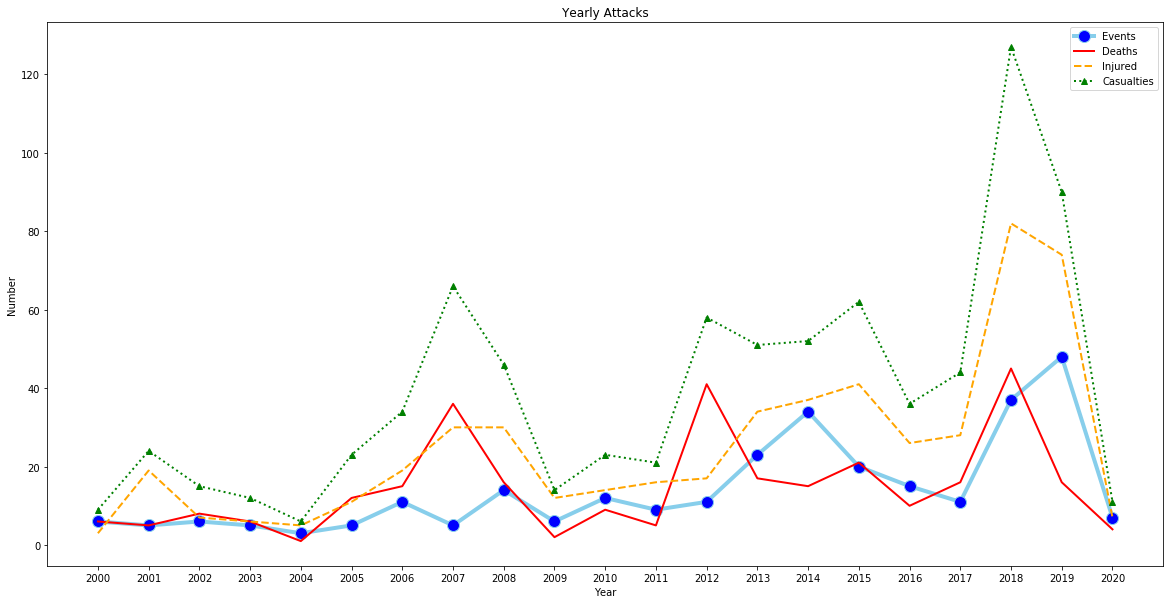

In [17]:
#This cell plots the Summary of Attacks for each year and shows t he trends of event counts, death counts, # injured, and total number of casualties. 
plt.figure(figsize=(20,10))
plt.plot( "Event_Count", data=by_Year, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label="Events")
plt.plot( "Killed", data=by_Year, marker='', color='red', linewidth=2, label="Deaths")
plt.plot( "Injured", data=by_Year, marker='', color='orange', linewidth=2, linestyle='dashed', label="Injured")
plt.plot("Casualties", data=by_Year, marker='^', color='green', linewidth=2,linestyle='dotted', label="Casualties")
plt.title('Yearly Attacks')
plt.ylabel('Number')
plt.xlabel('Year')
plt.legend()


The charts show that the number of events, injuries, deaths, and total casualties has been trending up in the last 20 years.  The steep decline in 2020 results from the data being pulled most recently by the author in early February 2020, the code will update if the table on the wikipedia page is updated and the notebook rerun.  

There are points where there are spikes in the number of casualties and the number of events which do not always align as seen in 2017, 2012, and 2014.  2018 and 2019 have the highest casualties, injuries, and evens in the last 10 years, but 2019 had about an average number of deaths.  

An interesting exercise would be to scrape the pages for earlier school shootings and see if and when the trend has ever consistently been down or if the increasing trend started around any socially significant events.  

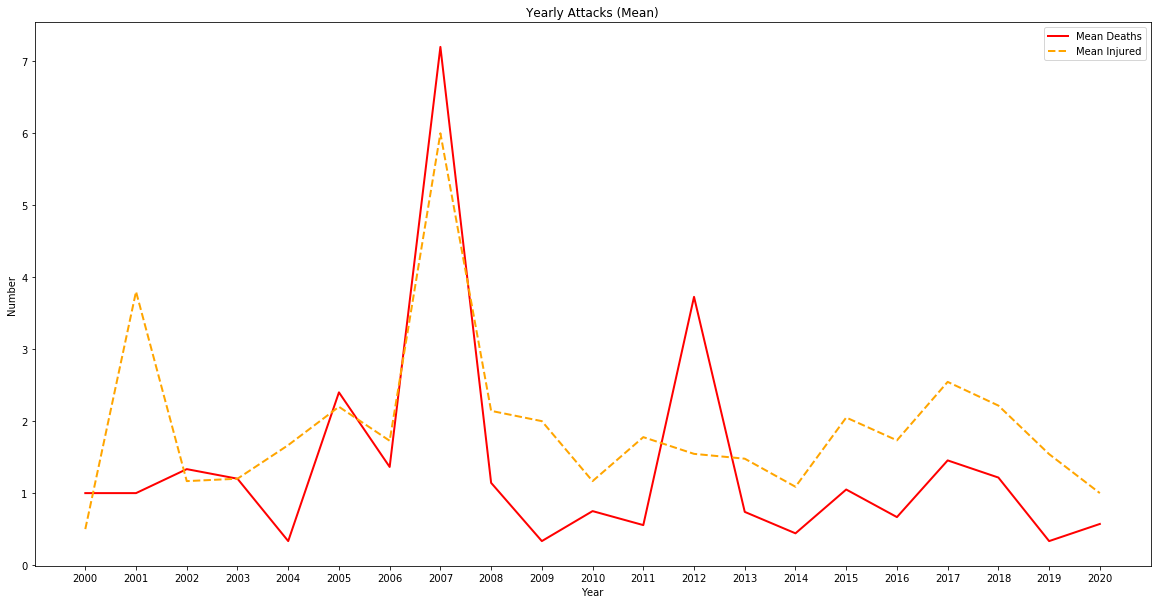

In [42]:
#This cell plots the Summary of Attacks for each year and shows the trends of death mean, mean injured
plt.figure(figsize=(20,10))
plt.plot( "Killed_Mean", data=by_Year, marker='', color='red', linewidth=2, label="Mean Deaths")
plt.plot( "Injured_Mean", data=by_Year, marker='', color='orange', linewidth=2, linestyle='dashed', label="Mean Injured")
plt.title('Yearly Attacks (Mean)')
plt.ylabel('Number')
plt.xlabel('Year')
plt.legend()


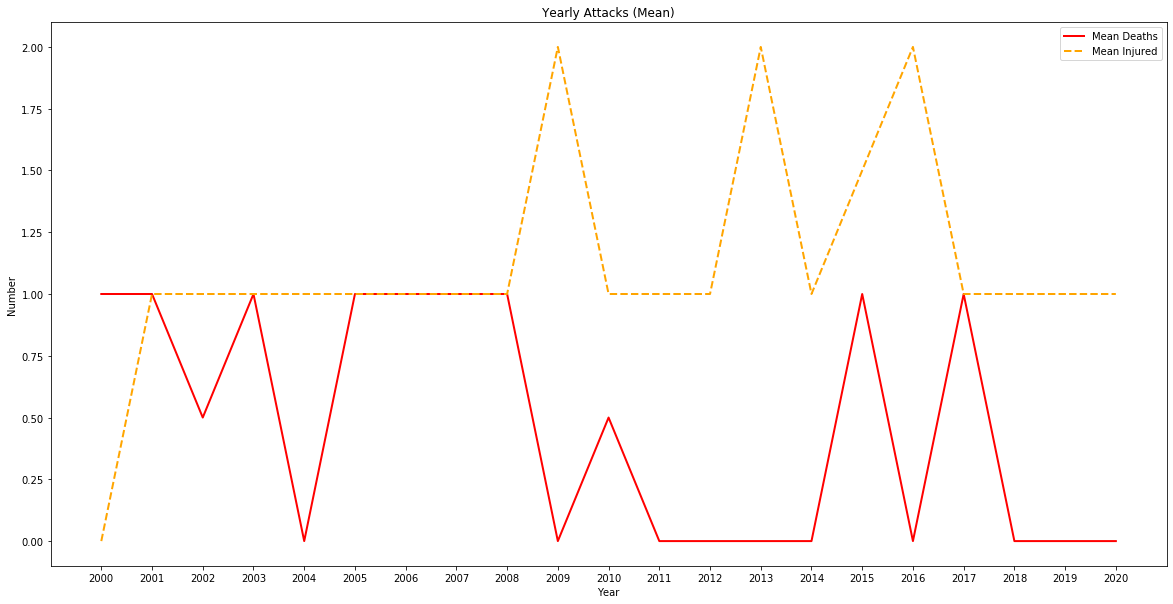

In [43]:
#This cell plots the Summary of Attacks for each year and shows the trends of death median, and median injured
plt.figure(figsize=(20,10))
plt.plot( "Killed_Median", data=by_Year, marker='', color='red', linewidth=2, label="Mean Deaths")
plt.plot( "Injured_Median", data=by_Year, marker='', color='orange', linewidth=2, linestyle='dashed', label="Mean Injured")
plt.title('Yearly Attacks (Mean)')
plt.ylabel('Number')
plt.xlabel('Year')
plt.legend()


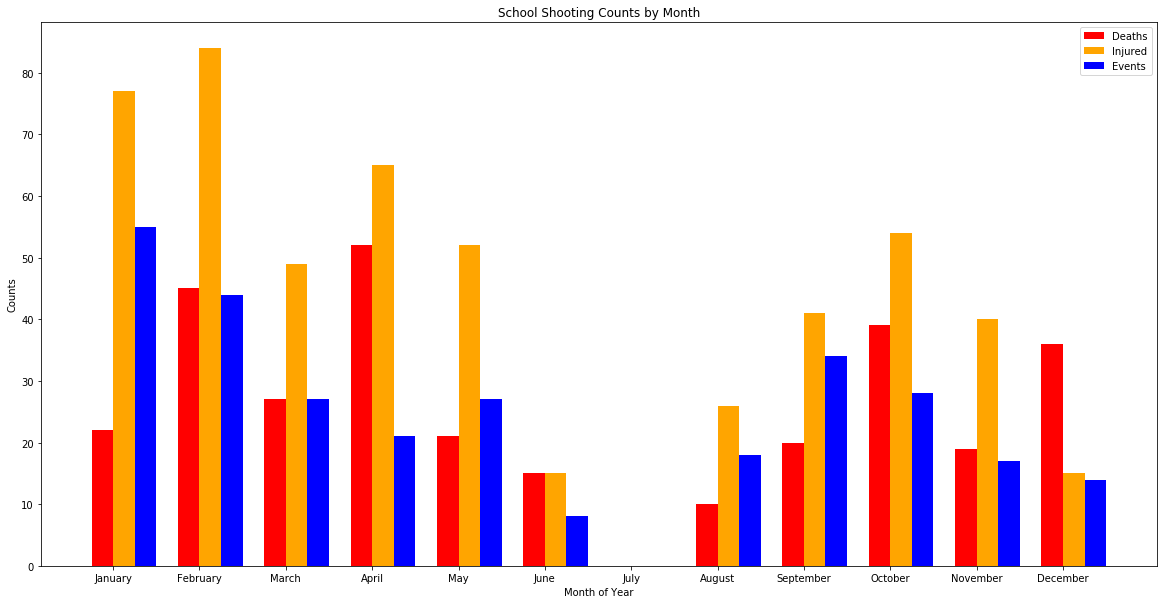

In [16]:
#This plot shows the attack summaries by month for Deaths, Injured, and Event counts. 
plt.figure(figsize=(20,10))
width = 0.25
x = np.arange(12)
plt.bar(x, by_Month['Killed'], width, color='red', label="Deaths")
plt.bar(x+width, by_Month['Injured'],width, color='orange', label="Injured")
plt.bar(x+width*2, by_Month['Event_Count'], width, color='blue', label='Events')
plt.ylabel('Counts')
plt.xlabel('Month of Year')
plt.title('School Shooting Counts by Month')
plt.xticks(x + width / 2, months)
plt.legend()



The plot above shows school shootings by month from 2000-early 2020. July has seen no attacks, which is reasonable since very few schools in the US are in session during July.  The number of events is highest in January, but the number of injured is highest in February and the number of deahts are highest in April. June has some of the lowest counts for all summaries which is reasonable since some schools are not in session in June.  Intereestingly, December has a lower number of events, which likely can be attributed with winter breaks, but it has a high count of deaths per event.  April is similar with the liklihood that spring break plays a role in the event totals. 

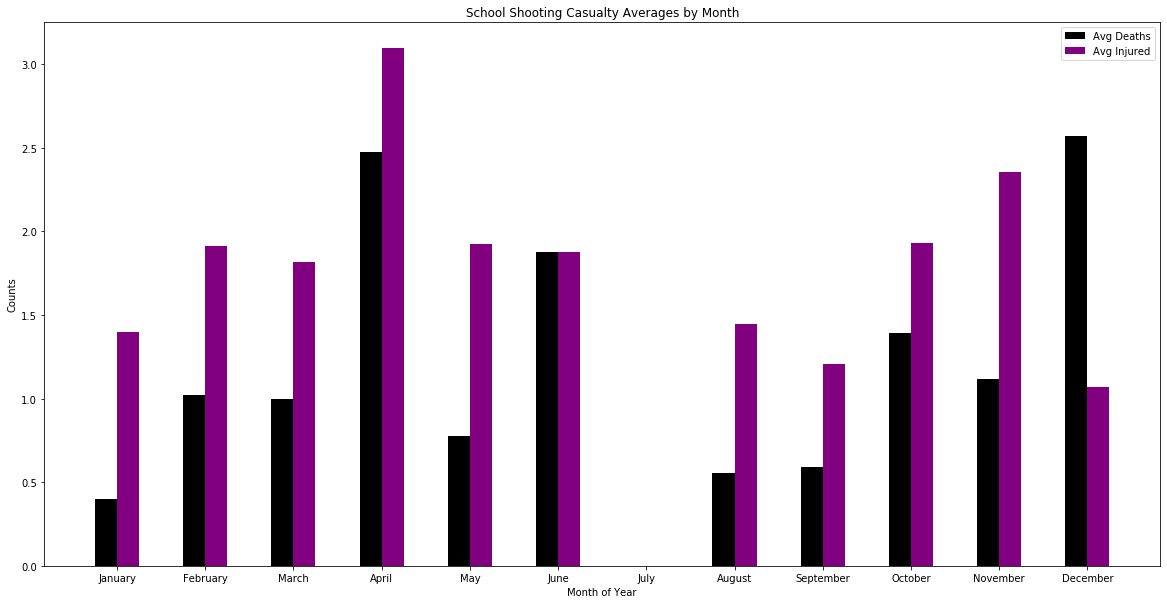

In [23]:
#This plot shows the attack summaries by month for Deaths and injuries using averages. 
plt.figure(figsize=(20,10))
width = 0.25
x = np.arange(12)
plt.bar(x, by_Month['Killed_Mean'], width, color='black', label="Avg Deaths")
plt.bar(x+width, by_Month['Injured_Mean'],width, color='purple', label="Avg Injured")
plt.ylabel('Counts')
plt.xlabel('Month of Year')
plt.title('School Shooting Casualty Averages for Events by Month')
plt.xticks(x + width / 2, months)
plt.legend()

The plot above shows the average number of people killed and injured during events per month of the year from 2000-early 2020. The average number of deaths during events per month is lowest in January and highest in December and April.  The average number of people injured for events in the month is lowest in December and highest in April.  This appears to show that December and April attacks are more likely to be deadly.  Interestingly, June attacks appear to have the same average of injured and killed. The averages should be taken with a grain of salt due the skew in the data.  

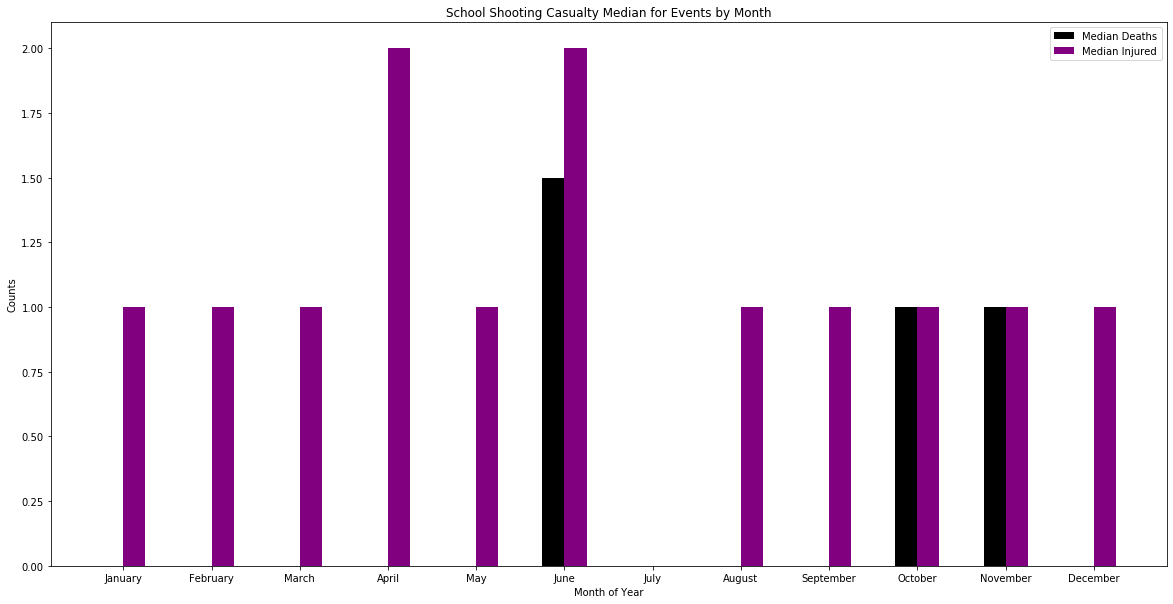

In [24]:
#This plot shows the attack summaries by month for Deaths and injuries using averages. 
plt.figure(figsize=(20,10))
width = 0.25
x = np.arange(12)
plt.bar(x, by_Month['Killed_Median'], width, color='black', label="Median Deaths")
plt.bar(x+width, by_Month['Injured_Median'],width, color='purple', label="Median Injured")
plt.ylabel('Counts')
plt.xlabel('Month of Year')
plt.title('School Shooting Casualty Median for Events by Month')
plt.xticks(x + width / 2, months)
plt.legend()

The plot above shows the median values for attacks occuring during each month for 2000-early 2020.  The 0 values for deaths for most months is a stark difference than the Mean plot and assists in showing how the data is skewed by a few attacks with large numbers of deaths. Based on the Median values, the deadliest months would be October, November, and June while April and June tend to lead to the most injured.  

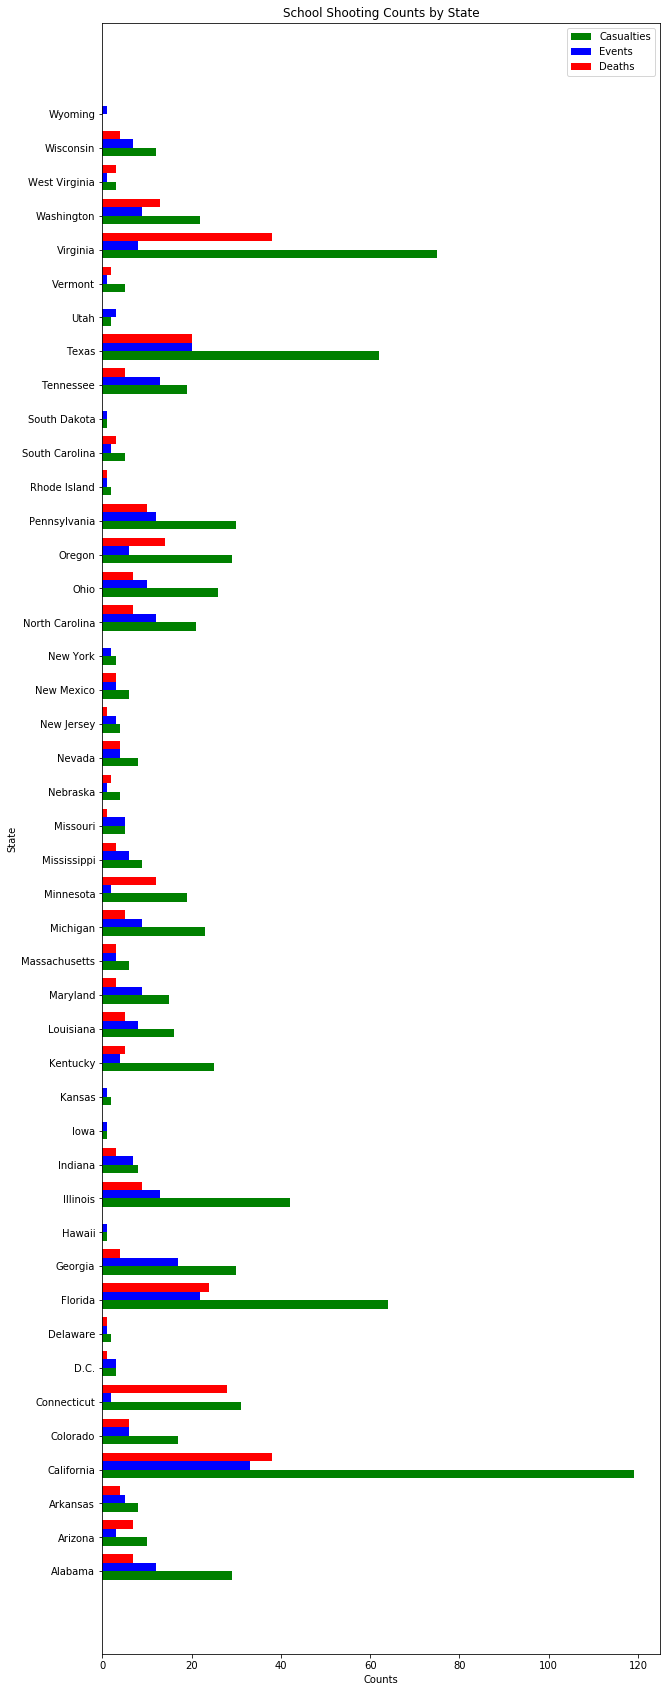

In [14]:
#This cell plots the summary of total casualties, deaths, and event counts by State if present. 
plt.figure(figsize=(10,30))
width = 0.25
x = by_State.reset_index().index
plt.barh(x, by_State['Casualties'], width, color='green', label="Casualties")
plt.barh(x+width, by_State['Event_Count'], width, color='blue', label='Events')
plt.barh(x+width*2, by_State['Killed'], width, color='red', label='Deaths')
plt.ylabel('State')
plt.xlabel('Counts')
plt.title('School Shooting Counts by State')
plt.yticks(x + width / 2, by_State.index)
plt.legend()


In [55]:
#This cell makes an attempt to classify the data based on school vs university.  There were some additional stop words added. 
#The top terms per cluster are printed as well as two predictions based on Commnets.  There is minimal data and no truely valid prediction is expected. 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

documents = df_all['Comments']

my_stop_words = text.ENGLISH_STOP_WORDS.union(["student", "year", "old", "shooting", "shot", "students", "school", "police"])

vectorizer = TfidfVectorizer(stop_words=my_stop_words)
X = vectorizer.fit_transform(documents)

true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top words per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),

print("\n")
print("Prediction")
print('university')
Y = vectorizer.transform(["A Student opened fire in the residence hall yesterday and shot 13 other people then himself. The only fatality was the gunman"])
prediction = model.predict(Y)
print(prediction)

print('high school')
Y = vectorizer.transform(["1 student was killed and 3 injured yesterday after a gunman opened fire in the cafeteria"])
prediction = model.predict(Y)
print(prediction)


Top terms per cluster:
Cluster 0:
 high
 university
 injured
 campus
 state
 fired
 game
 killed
 man
 person
Cluster 1:
 murder
 high
 charged
 sentenced
 years
 attempted
 15
 arrested
 prison
 later


Prediction
university
[0]
high school
[0]
